# Benchmark of GLASSVIEWER 

Glassviewer is a FORK of Pyscal, which is modified and improved for Metal Glass data post-processing tasks by Zihao Bai, Jilin University.
This Benchmark uses a POSCAR file from MD of aluminium melting process. In order to test the partial PDF module and SRO module, we label the atoms into Al1 and Al2.(in POSCAR they are labeled as Al and Cs)

The properties of POSCAR are as following:

Box parameter:

    55.996 0.0 0.0
    0.0 56.923 0.0
    0.0 0.0 56.369
    
Atom Numbers:

    Al1 Al2
    10000 976 


## Initialization

In [1]:
import pyscal as pc
import pyscal.traj_process as ptp
import matplotlib.pyplot as plt
import numpy as np

## Split Trajectory

In [ ]:
files=ptp.split_trajectory('XDATCAR',format='poscar',makedir=True) 
file=files[0]

If you need to analyze a certain poscar within a MD trajectory, then you should split the trajectory first.

## Read Files

Here we do not use the splitted trajectory above. Instead we choose a POSCAR which satisfy the condition described in the summary in the header.

In [2]:
file='POSCAR_Al1_Al2'
format="poscar"
sys1 = pc.System()
sys1.read_inputfile(file, format=format)#format{'lammps-dump', 'poscar', 'ase', 'mdtraj'}

## Find Neighbors

We must run the finding-neighbor algorithms before we calculate any property which is related to atom neighbors.

In [3]:
sys1.find_neighbors(method="voronoi")

method can be selected among "cutoff voronoi number", details can refer to PYSCAL's document.

## PDF-Total (Parallelization and improved by GlassViewer)

I made much improvement for PDF functions such as support for multithreading and long-range calculation.

This function is designed to be very smart to make sure PDF calculation occupies little time.

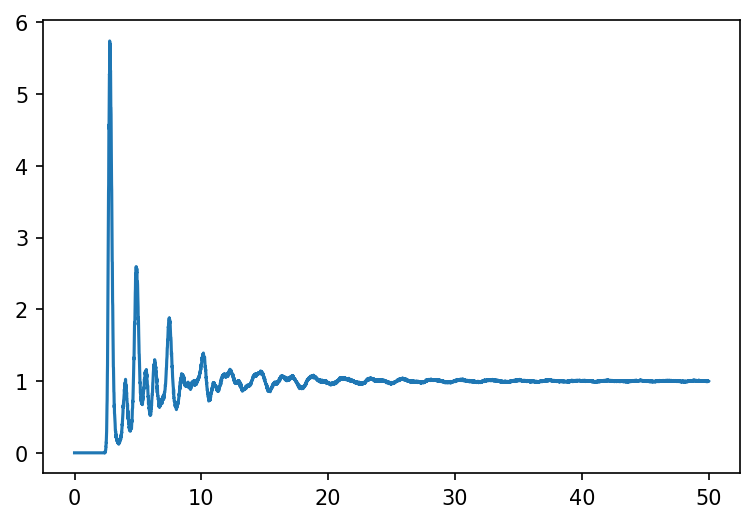

In [28]:

histnum=5000#直方图分割数量(密度)
pdf, r=sys1.calculate_pdf(histobins=histnum,histomin=0,cut=50,threadnum=20)
plt.figure(dpi=150)
plt.plot(r,pdf);


## PDF-Partial (supported by GlassViewer)

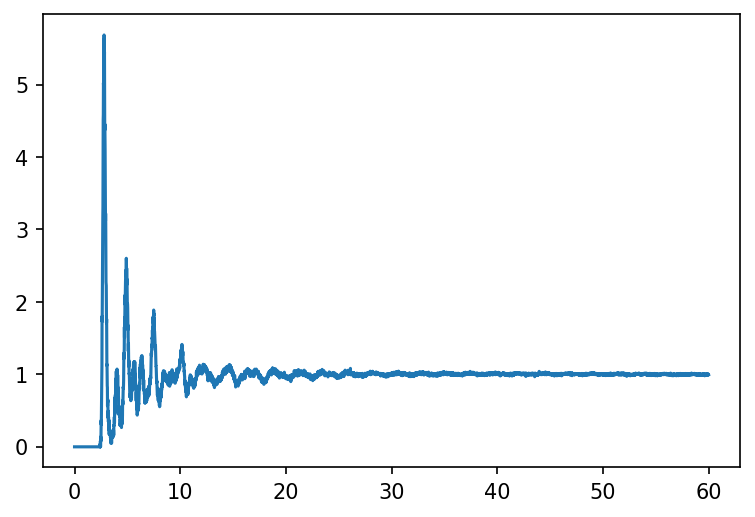

In [6]:
histnum=5000#直方图分割数量(密度)
pdfp, r=sys1.calculate_pdf(histobins=histnum,histomin=0,cut=60,partial=True,centertype=1,secondtype=2)
plt.figure(dpi=150)
plt.plot(r,pdfp);

## Bond Angle Distribution (supported by GlassViewer)

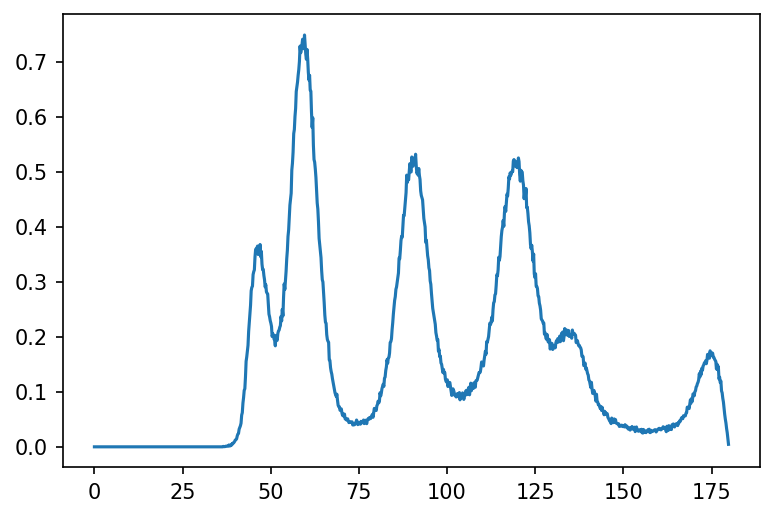

In [7]:
bad, r2=sys1.calculate_bad(histobins=1000,histomin=0,histomax=np.pi);
plt.figure(dpi=150)
plt.plot(r2*180/np.pi,bad);

## Structure Factor-FFT Method (supported by GlassViewer)

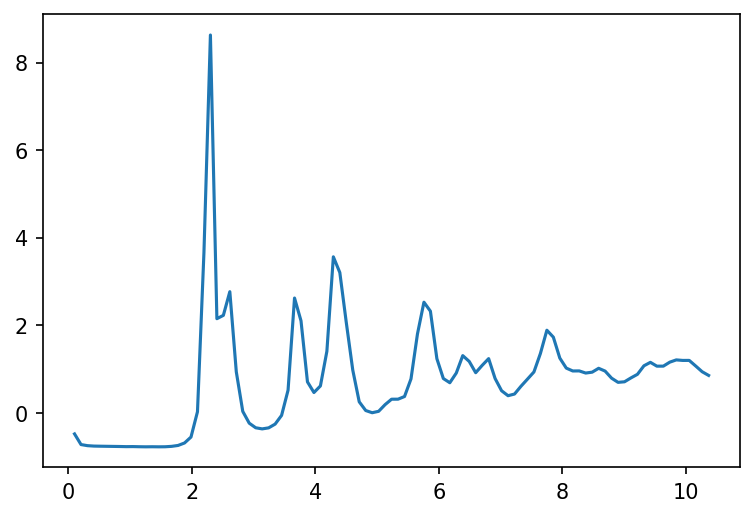

In [8]:
sf,q=sys1.calculate_sf(pdf, r,0);
plt.figure(dpi=150)
plt.plot(q[0:int(len(q)/20/histnum*2000)],sf[0:int(len(sf)/20/histnum*2000)]);


## Structure Factor-Integration Method (supported by GlassViewer)

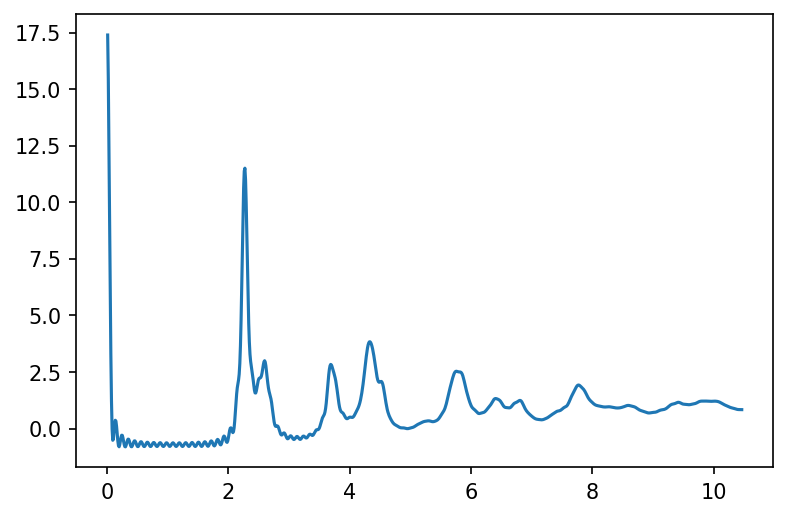

In [9]:
sf,q=sys1.calculate_sf(pdf, r,10);
plt.figure(dpi=150)
plt.plot(q[0:int(len(q)/20/histnum*2000)],sf[0:int(len(sf)/20/histnum*2000)]);

## SRO-Cowley

In [10]:
SRO_Cowley=sys1.calculate_pmsro(reference_type=1,compare_type=2)
print('The Cowley SRO is '+str(SRO_Cowley[0]))

The Cowley SRO is 0.0393368970897108


## SRO-Cargill-Spaepen (supported by GlassViewer)

In [11]:
SRO_CS_unnorm=sys1.calculate_pmsro_CS(reference_type=1,compare_type=2,normalization=False)
SRO_CS_norm=sys1.calculate_pmsro_CS(reference_type=1,compare_type=2,normalization=True)
print('The Cowley SRO (unnormalized) is '+str(SRO_CS_unnorm))
print('The Cowley SRO (nnormalized)  is '+str(SRO_CS_norm))


The Cowley SRO (unnormalized) is -0.03794064956327503
The Cowley SRO (nnormalized)  is -0.3892886598620064


## CNA

In [12]:
CNA=sys1.calculate_cna()
print('CNA statistics of the system is '+str(CNA))
print('the structure number of atom0 is: '+str(sys1.atoms[0].structure))

CNA statistics of the system is {'others': 4038, 'fcc': 5738, 'hcp': 1139, 'bcc': 61, 'ico': 0}
the structure number of atom0 is: 2


## Voronoi Structure Identification

In [13]:
sys1.calculate_vorovector()
print('the vorovector (n3, n4, n5, n6) for Atom 0 is '+str(sys1.atoms[0].vorovector))

the vorovector (n3, n4, n5, n6) for Atom 0 is [0, 14, 0, 0]


## BOO_Qn

In [14]:
sys1.calculate_q([2,4,5,6],averaged=False)
BOO=sys1.get_qvals([2,4,5,6],averaged=False)
print('the BOO number (q2, q4, q5, q6) for Atom 0 is '+str(BOO[0][0])+' '+str(BOO[0][1])+' '+str(BOO[0][2])+' '+str(BOO[0][3]))

the BOO number (q2, q4, q5, q6) for Atom 0 is 0.09328374905692187 0.06986055915482668 0.10704426180048338 0.07135551396271009


## BOO_Wn (supported by GlassViewer)

In [26]:
sys1.calculate_w([2,4,5,6],averaged=False)# Calculate Wn numbers for W2 W4 W5 W6 
sys1.calculate_w([2,4,5,6],averaged=True)# Calculate Averaged Wn numbers
print('the Wn numbers for Atom 0 is:\n',sys1.atoms[0].w)
print('\nthe Averaged Wn numbers for Atom 0 is:\n',sys1.atoms[0].aw)
# n should be between 2 and 12. Because only W2 W4 W5 W6 are calculated, all others are -1. 

the Wn numbers for Atom 0 is:
 [-4.437670210027433e-05, -1.0, -9.20376393464802e-07, 6.917797568576167e-05, -7.095051347829148e-05, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

the Averaged Wn numbers for Atom 0 is:
 [0.3114912872553408, -1.0, 0.09551097780169093, 1.136278747045702, 0.03581671881184495, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


## Output the Atom Configuration and Atom Property

In [ ]:
sys1.to_file('out',format='poscar')#We can directly output the atom configuration into poscar 
sys1.to_file('out'+file,format='lammps-dump',customkeys=['aq2','aq4','aq5','aq6'])
#aqn for  BOO-average-Qn, qn for BOO-Qn, other key name is the same with the attribute name, only lammps support custumkeys


# Visualization tool

This is a interactive tool must be run in web jupyternotebook.

In [16]:
sys1.show()

interactive(children=(FloatSlider(value=1.0, description='radius', max=30.0, min=1.0, step=1.0), Text(value='S…